# Ch 07. sentence generation using RNN
in this chapter, we learn sentence generation.  
seq2seq translate one sequential information into other sequential information.  

## 7.1 sentence generation using language model.
language models can be used in field like translation, speech recognition, sentence generation.

### 7.1.1 sequence of sentence generation using RNN.
we made Time LSTM, Time-Affine layers.  
in our example("you say goodbye and i say hello."), if machine gets 'you', it predcts 'say'.  
we could deterministically choose most probable next words, or we can consider probability too.   
and we can repeat this process until we make 'eos'  
notice this sentence is from machine.  

### 7.1.2 implementing sentence generation

In [ ]:
# ch06/Rnnlm
# ch07rnnlm_gen.py 

import sys
sys.path.append('...')
import numpy as np
from common.functions import softmax
from ch06.rnnlm import Rnnlm
from ch06.better_rnnlm import BetterRnnlm

class RnnlmGen(Rnnlm):
    def generate(self, start_id, skip_ids=None, sample_size = 100):
        word_ids = [start_id]
        
        x = start_id
        while len(word_ids) < sample_size:
            x = np.array(x).reshape(1,1)
            score = self.predict(x)
            p = softmax(score.flatten)
            
            sampled = np.random.choice(len(p), size = 1, p = p)
            if(skip_ids is None) or (sampled not in skip_ids):
                x = sampled
                word_ids.append(int(x))
                
        return word_ids

now, lets generate sentences. without training. 

In [13]:
#ch07/generate_text.py

import sys
sys.path.append('...')
from rnnlm_gen import RnnlmGen
from dataset import ptb 

corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)
corpus_size = len(corpus)

model = RnnlmGen()
#model.load_params('../ch06/Rnnlm.pkl')

#start and skip word generate
start_word = 'you'
start_id = word_to_id[start_word]
skip_word = ['N', '<unk>', '$']
skip_id = [word_to_id[w] for w in skip_word]


# sentence generation
word_ids = model.generate(start_id, skip_id)
txt = ' '.join([id_to_word[i] for i in word_ids])
txt = txt.replace(' <eos>', '.\n')
print(txt)

you magnetic minimize refineries morgenzon lifting ecological charge spirits disaster outfit hhs plc pregnant advanced insiders closes option intervened dissent mehl periodic rebounding stockholm a.g. spending constituents preferences across insist alarm frankfurt widespread first-half signing sagging standardized contest avon liquidation spots ernest airplanes mr. revco unpublished surprises nasd christmas punitive dallas batibot osha develops arrangements microwave introduce integrated devoe clara regions instructed underwritten champion environmentalism indian upbeat auctioned honduras convictions stones stock-market depletion bradstreet arts resilience aggressively enthusiasm cocoa southam kelly stories cutbacks voter bottle asserted demands cell defects malaysia architectural briggs staffers unloading bail eye fall testified afraid mae


generate() gives list of word_id, so, we need to convert them into text we can read by join()  
[Seperator]join(list) method concatinate list with seperator within.  

In [14]:
corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)
corpus_size = len(corpus)

model = RnnlmGen()
model.load_params('../ch06/Rnnlm.pkl')

#start and skip word generate
start_word = 'you'
start_id = word_to_id[start_word]
skip_word = ['N', '<unk>', '$']
skip_id = [word_to_id[w] for w in skip_word]


# sentence generation
word_ids = model.generate(start_id, skip_id)
txt = ' '.join([id_to_word[i] for i in word_ids])
txt = txt.replace(' <eos>', '.\n')
print(txt)

you see that the ratio of security you can move to remove the bad monetary quality of crisis.
 i fails need mr. gorbachev 's surge for your spot.
 needs a regained of approximately five studies ahead adjustment out of toledo first boston 's news taiwan which office painewebber inc. is designed to exclude videocassette 's most exchanges and health care.
 mr. trump also said a number of row costs were that it may confirm prevent temple.
 and unwanted subsidize trade division plans to sell a real deal and most likely.
 the announcement itself would need


now sentence is more consistent. its kinda spooky.  
there are much to improve still.

### 7.1.3 to better sentence.
how about we use betterRnn we made in ch06?

In [33]:
from common.np import *
from rnnlm_gen import BetterRnnlmGen
from dataset import ptb


corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)
corpus_size = len(corpus)


model = BetterRnnlmGen()
model.load_params('../ch06/BetterRnnlm.pkl')

# start 문자와 skip 문자 설정
start_word = 'you'
start_id = word_to_id[start_word]
skip_words = ['N', '<unk>', '$']
skip_ids = [word_to_id[w] for w in skip_words]
# 문장 생성
word_ids = model.generate(start_id, skip_ids)
txt = ' '.join([id_to_word[i] for i in word_ids])
txt = txt.replace(' <eos>', '.\n')

print(txt)


model.reset_state()

start_words = 'the meaning of life is'
start_ids = [word_to_id[w] for w in start_words.split(' ')]

for x in start_ids[:-1]:
    x = np.array(x).reshape(1, 1)
    model.predict(x)

word_ids = model.generate(start_ids[-1], skip_ids)
word_ids = start_ids[:-1] + word_ids
txt = ' '.join([id_to_word[i] for i in word_ids])
txt = txt.replace(' <eos>', '.\n')
print('-' * 50)
print(txt)


you can be approved at least about around of two helicopter members as they will real merge are processors.
 delaware dollar was a anti-drug foundation proceedings as the mother who assume that there was an buyer of copyright and event traffickers.
 during three years profit in filing healthy increases in loans the bat shipments will go being bought after takeover charges it seems to provide taxes things.
 alternative figures while loans inhibit sales pursue that.
 it 's very expectations killing the firm using a technicians to make the strategy for fluor banking until the oct. year
--------------------------------------------------
the meaning of life is forced securities any popular department that is a heavy policyholders mr. jones said.
 the editor did n't identify such news in ironic and other defendants waiting to attract the firm with the board it under a seasonally dangerous note and a deficit of margaret lawson might be one big resort ending in quotas to block speculation that

its even spookier!  
it got much better, but we have a long way in terms of semantics.

## 7.2 seq2seq
time-series data : language, speech, video, ...  
we can consider transformation between time-series data to time-series data.  
example: translation, speech recognition, chat-bot, complier...  
we will use seq2seq. using 2 RNN

### 7.2.1 how does seq2seq work?
we use two module, Encoder and Decoder.  
'나는 고양이로소이다' =(encoder)=(decoder) => 'i am a cat'  
encoder compresses the information.  
  
encoder  is LSTM, and gives hidden vector h.  
note that size of vector is fixed. encode means transform arbitrary size sentense into fixed size vector.  
  
decoder is also LSTM, gets h and eos.  

### 7.2.2. toy problem for time series data transform
we want machine to transform 57+5 into 62, and so on.  

### 7.2.3 variable length time-series data
we want same size for data. we will just use padding.  
machine will learn padded character. so if you want to be precise, you need additional process. 

### 7.2.4 addition dataset
dataset/addition.txt  
50,000 examples.

In [1]:
import sys
sys.path.append('..')
from dataset import sequence

(x_train, t_train), (x_test, t_test) = sequence.load_data('addition.txt', seed='1984') #seed?
char_to_id, id_to_char = sequence.get_vocab()

print(x_train.shape, t_train.shape)
print(x_test.shape, t_test.shape)

print(x_train[0])
print(t_train[0])

print(''.join([id_to_char[c] for c in x_train[0]]))
print(''.join([id_to_char[c] for c in t_train[0]]))


(45000, 7) (45000, 5)
(5000, 7) (5000, 5)
[ 3  0  2  0  0 11  5]
[ 6  0 11  7  5]
71+118 
_189 


## 7.3 seq2seq implementation

In [2]:
#ch07/seq2seq
from common.time_layers import *
from common.base_model import BaseModel


class Encoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')

        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=False)

        self.params = self.embed.params + self.lstm.params
        self.grads = self.embed.grads + self.lstm.grads
        self.hs = None

    def forward(self, xs):
        xs = self.embed.forward(xs)
        hs = self.lstm.forward(xs)
        self.hs = hs
        return hs[:, -1, :]

    def backward(self, dh):
        dhs = np.zeros_like(self.hs)
        dhs[:, -1, :] = dh

        dout = self.lstm.backward(dhs)
        dout = self.embed.backward(dout)
        return dout


In [3]:
class Decoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True)
        self.affine = TimeAffine(affine_W, affine_b)

        self.params, self.grads = [], []
        for layer in (self.embed, self.lstm, self.affine):
            self.params += layer.params
            self.grads += layer.grads

    def forward(self, xs, h):
        self.lstm.set_state(h)

        out = self.embed.forward(xs)
        out = self.lstm.forward(out)
        score = self.affine.forward(out)
        return score

    def backward(self, dscore):
        dout = self.affine.backward(dscore)
        dout = self.lstm.backward(dout)
        dout = self.embed.backward(dout)
        dh = self.lstm.dh
        return dh

    def generate(self, h, start_id, sample_size):
        sampled = []
        sample_id = start_id
        self.lstm.set_state(h)

        for _ in range(sample_size):
            x = np.array(sample_id).reshape((1, 1))
            out = self.embed.forward(x)
            out = self.lstm.forward(out)
            score = self.affine.forward(out)

            sample_id = np.argmax(score.flatten())
            sampled.append(int(sample_id))

        return sampled

Decoder's forward() is not generate().  
so we made another method generate()  
forward : for training.  

In [4]:

class Seq2seq(BaseModel):
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        self.encoder = Encoder(V, D, H)
        self.decoder = Decoder(V, D, H)
        self.softmax = TimeSoftmaxWithLoss()

        self.params = self.encoder.params + self.decoder.params
        self.grads = self.encoder.grads + self.decoder.grads

    def forward(self, xs, ts):
        decoder_xs, decoder_ts = ts[:, :-1], ts[:, 1:]

        h = self.encoder.forward(xs)
        score = self.decoder.forward(decoder_xs, h)
        loss = self.softmax.forward(score, decoder_ts)
        return loss

    def backward(self, dout=1):
        dout = self.softmax.backward(dout)
        dh = self.decoder.backward(dout)
        dout = self.encoder.backward(dh)
        return dout

    def generate(self, xs, start_id, sample_size):
        h = self.encoder.forward(xs)
        sampled = self.decoder.generate(h, start_id, sample_size)
        return sampled


### 7.3.4 evaluating seq2seq
basically, seq2seq trains like below: 
1. choosing minibatch from traing data
2. get gradient from minibatch
3. update parameter from grad

In [5]:
# check : ch07/train_seq2seq.py
# check : common/util.py => eval_seq2seq

In [7]:
#import train_seq2seq

## 7.4 seq2seq improvement
we will learn two ways of improving seq2seq's training speed. 

### 7.4.1 Reverse
57 + 5 => 5 + 57  
we add follwing code in train_seq2seq.py

x.train, x_test = x.train[:, ::-1], x_test[:, ::-1]  
this notation revreses the row of matrix.

In [9]:
#import train_seq2seq

### 7.4.2 Peeky
h is the ONLY information decoder gets.  
h is super important, maybe we can use it more.  
we can give h to other layers of decoder!  
=> transfer h into EVERY affine, LSTM  
(for affine layer, vectors are actually concatinated)
  
i changed train_seq2seq little bit. now here we go.

| 에폭 1 |  반복 1 / 351 | 시간 0[s] | 손실 2.57
| 에폭 1 |  반복 21 / 351 | 시간 0[s] | 손실 2.48
| 에폭 1 |  반복 41 / 351 | 시간 0[s] | 손실 2.20
| 에폭 1 |  반복 61 / 351 | 시간 1[s] | 손실 1.99
| 에폭 1 |  반복 81 / 351 | 시간 1[s] | 손실 1.89
| 에폭 1 |  반복 101 / 351 | 시간 2[s] | 손실 1.82
| 에폭 1 |  반복 121 / 351 | 시간 2[s] | 손실 1.82
| 에폭 1 |  반복 141 / 351 | 시간 2[s] | 손실 1.80
| 에폭 1 |  반복 161 / 351 | 시간 3[s] | 손실 1.79
| 에폭 1 |  반복 181 / 351 | 시간 3[s] | 손실 1.78
| 에폭 1 |  반복 201 / 351 | 시간 3[s] | 손실 1.77
| 에폭 1 |  반복 221 / 351 | 시간 4[s] | 손실 1.76
| 에폭 1 |  반복 241 / 351 | 시간 4[s] | 손실 1.76
| 에폭 1 |  반복 261 / 351 | 시간 5[s] | 손실 1.75
| 에폭 1 |  반복 281 / 351 | 시간 5[s] | 손실 1.74
| 에폭 1 |  반복 301 / 351 | 시간 5[s] | 손실 1.74
| 에폭 1 |  반복 321 / 351 | 시간 6[s] | 손실 1.73
| 에폭 1 |  반복 341 / 351 | 시간 6[s] | 손실 1.73
Q 77+85  
T 162 
X 100 
---
Q 975+164
T 1139
X 1013
---
Q 582+84 
T 666 
X 102 
---
Q 8+155  
T 163 
X 100 
---
Q 367+55 
T 422 
X 1023
---
Q 600+257
T 857 
X 1023
---
Q 761+292
T 1053
X 1023
---
Q 830+597
T 1427
X 1111
---
Q 26+838

c:\Users\GAILAB\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 50640 (\N{HANGUL SYLLABLE E}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\GAILAB\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 54253 (\N{HANGUL SYLLABLE POG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\GAILAB\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\GAILAB\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 54869 (\N{HANGUL SYLLABLE HWAG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\GAILAB\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


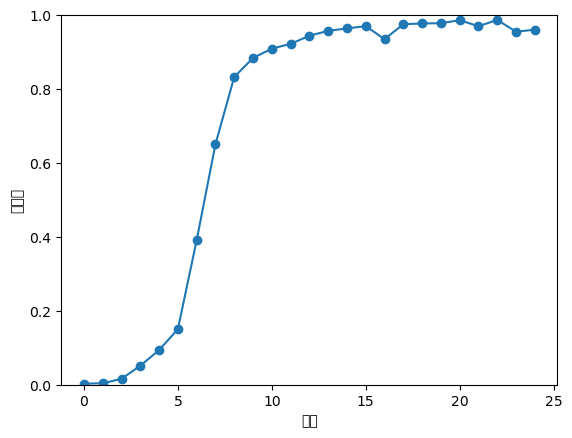

In [10]:
import train_seq2seq

## 7.5 application that uses seq2seq

### 7.5.1 chatbot 
consider input as 'user's sentence' and output as 'response'  

### 7.5.2 algorithm learning 
we made machine learn addition. but we know same principle can be applied for much much complicate problem.  
like python code!

### 7.5.3 image captioning
seq2seq can process image or sound as well.  
image captioning translate 'image' into 'sentence'  
basically, img -(CNN)-> (Affine) -> (seq2seq)  
in this case, CNN flatten out and use FC(affine).

## 7.6 Conclusion 
we learned sentence generation, and we made machine to learn addition problem.  
seq2seq is just 2 RNN. very simple. but very versatile.  
we saw two ways to improve seq2seq(Reverse, Peeky)  
  
Next chapter, we improve our seq2seq to next level. with 'ATTENTION'.  
it is one of the most important concept in deeplearning! 